In [1]:
import pandas as pd
import numpy as np


In [2]:
# similarity matrix and CDI
#step 1: clean CDI data
    #define PLT done
    #define Late Bloomers done
    #think through how to get trajectories for each child
    #ensure once a word is learned, it stays learned
#step 2:
#   build a network for each child at each time point using 
    # (a) similarity matrix and 
    # (b) phono matrix
# step 3: built random networks for each child at each time point
    # preseverve size and how to connect to determine if network structure 
    # arises from english language or child-specific learning patterns 
# step 4: measure network properties at each time point for each child
    # size
    # clustering coefficient
    # average path length
    # mean degree 
    # redundancy
    # average geodesic distance
# step 5: statistical analyses
    # compare network properties across PLT and Late Bloomer groups
        # determine differences controlling for vocabulary size
    # compare to random networks
# step 6: visualizations


Step 1: Cleaning

In [3]:
#reading in files
sim_mat = pd.read_csv("/Users/abbyhultquist/Documents/First Year Project/nouns.csv", index_col=0)
CDI_raw = pd.read_csv("/Users/abbyhultquist/Documents/First Year Project/CDI_raw.csv")
CDI = CDI_raw.copy()
CDI = CDI.sort_values(['child_id', 'session_num'])

#word columns: columns in the matrix that are 1 or 0 of known / not known
word_cols = CDI.columns[19:].tolist()

word_cols
print("word_cols", word_cols)
# Remove children with less than 5 sessions
session_counts = CDI.groupby('child_id')['session_num'].count()
valid_children = session_counts[session_counts >= 4].index
CDI = CDI[CDI['child_id'].isin(valid_children)]

print(f"Number of children after filtering: {CDI['child_id'].nunique()}")
print(f"Total rows: {len(CDI)}")

#how many words are there total? 
total_words = len(word_cols)
print(f"Total number of words in CDI: {total_words}")

word_cols ['baa baa', 'choo choo', 'cockadoodledoo', 'grr', 'meow', 'moo', 'ouch', 'quack quack', 'uh oh', 'vroom', 'woof woof', 'yum yum', 'alligator', 'animal', 'ant', 'bear', 'bee', 'bird', 'bug', 'bunny', 'butterfly', 'cat', 'chicken(animal)', 'cow', 'deer', 'dog', 'donkey', 'duck', 'elephant', 'fish(animal)', 'frog', 'giraffe', 'goose', 'hen', 'horse', 'kitty', 'lamb', 'lion', 'monkey', 'moose', 'mouse', 'owl', 'penguin', 'pig', 'pony', 'puppy', 'rooster', 'sheep', 'squirrel', 'teddybear', 'tiger', 'turkey', 'turtle', 'wolf', 'zebra', 'airplane', 'bicycle', 'boat', 'bus', 'car', 'fire truck', 'helicopter', 'motorcycle', 'sled', 'stroller', 'tractor', 'train', 'tricycle', 'truck', 'ball', 'balloon', 'bat', 'block', 'book', 'bubbles', 'chalk', 'crayon', 'doll', 'game', 'glue', 'pen', 'pencil', 'play dough', 'present', 'puzzle', 'story', 'toy', 'apple', 'applesauce', 'banana', 'beans', 'bread', 'butter', 'cake', 'candy', 'carrots', 'cereal', 'cheerios', 'cheese', 'chicken(food)', 'ch

In [15]:
print(CDI.columns[1:18])

Index(['study id', 'study', 'gender', 'age', 'birthday', 'session_date',
       'session_num', 'total num sessions', 'words_spoken', 'items excluded',
       'percentile', 'extra categories', 'revision', 'languages',
       'num languages', 'cdi type', 'hard of hearing'],
      dtype='object')


In [4]:
# Ensure words stay learned once acquired (cumulative knowledge)
grouped = CDI.groupby('child_id')
for child_id, group in grouped:
    group = group.sort_values('session_num')
    for word in word_cols:
        # Find first session where word is known
        known_sessions = group[group[word] == 1]['session_num']
        if not known_sessions.empty:
            first_known = known_sessions.min()
            # Set word as known from first_known onwards
            CDI.loc[(CDI['child_id'] == child_id) & (CDI['session_num'] >= first_known), word] = 1

# Recalculate vocab_size after ensuring cumulative knowledge
CDI['vocab_size'] = CDI[word_cols].sum(axis=1)

In [5]:
#defining late talkers (0 = TT, 1 = LT)
#defining PLT (0 = Late bloomer, 1 = PLT, NA means they are a TT)


CDI["Late_Talker"] = 0
CDI["Persistent_Late_Talker"] = np.nan #Only LT get set to 0 or 1

grouped = CDI.groupby('child_id')

for child_id, group in grouped:
    first_session = group['session_num'].min()
    last_session = group['session_num'].max()
    
    # Check first session for this child
    first_session_data = group[group['session_num'] == first_session]
    
    if len(first_session_data) > 0:
        if first_session_data['percentile'].values[0] < 20:
            CDI.loc[CDI['child_id'] == child_id, 'Late_Talker'] = 1
        else:
            CDI.loc[CDI['child_id'] == child_id, 'Late_Talker'] = 0
    
    # Check last session for this child
    last_session_data = group[group['session_num'] == last_session]
    
    if len(last_session_data) > 0:
        late_talker_status = CDI.loc[CDI['child_id'] == child_id, 'Late_Talker'].values[0]
        
        if late_talker_status == 1:  # Was a late talker
            if last_session_data['percentile'].values[0] < 20:  # FIXED: Still below 20%
                CDI.loc[CDI['child_id'] == child_id, 'Persistent_Late_Talker'] = 1
            else:  # Improved (late bloomer)
                CDI.loc[CDI['child_id'] == child_id, 'Persistent_Late_Talker'] = 0
        else:  # Not a late talker
            CDI.loc[CDI['child_id'] == child_id, 'Persistent_Late_Talker'] = np.nan  # FIXED: Use np.nan

# Verify - FIXED: Use correct column names
print("Late Talkers:", CDI[CDI['Late_Talker'] == 1]['child_id'].nunique())
print("Persistent Late Talkers:", CDI[CDI['Persistent_Late_Talker'] == 1]['child_id'].nunique())
print("Late Bloomers:", CDI[(CDI['Late_Talker'] == 1) & (CDI['Persistent_Late_Talker'] == 0)]['child_id'].nunique())

Late Talkers: 41
Persistent Late Talkers: 8
Late Bloomers: 33


In [6]:
CDI["vocab_size"]

0        91.0
1       161.0
2       201.0
3       227.0
4       265.0
        ...  
1159     71.0
1160    145.0
1161    286.0
1162    401.0
1163    549.0
Name: vocab_size, Length: 1155, dtype: float64

In [12]:
from scipy import stats

# Find and remove outliers
outliers_sessions = set(CDI[CDI['session_num'] > 12]['child_id'])
outliers_vocab = set(CDI[CDI['vocab_size'] > len(word_cols)]['child_id'])

all_outliers = outliers_sessions | outliers_vocab | outliers_zscore

print(f"Removed {len(all_outliers)} children:")
print(f"  - {len(outliers_sessions)} for session_num > 12")
print(f"  - {len(outliers_vocab)} for vocab_size > # words in CDI")


CDI = CDI[~CDI['child_id'].isin(all_outliers)].copy()

Removed 1 children:
  - 0 for session_num > 12
  - 0 for vocab_size > # words in CDI


In [8]:
#trajectory for each child

slopes = {}
for child_id, group in CDI.groupby('child_id'):
    group = group.sort_values('session_num')
    sessions = group['session_num'].values
    vocabs = group['vocab_size'].values
    if len(sessions) > 1:
        slope = np.polyfit(sessions, vocabs, 1)[0] #accounts for gaps such as if children skipped a session
    else:
        slope = np.nan
    slopes[child_id] = slope

CDI['trajectory_slope'] = CDI['child_id'].map(slopes)


In [9]:
# Alternative: Average slope per unique child

# Get one row per child with their slope
unique_children = CDI.drop_duplicates(subset='child_id')

late_bloomer_slopes = unique_children[(unique_children['Late_Talker'] == 1) & 
                                      (unique_children['Persistent_Late_Talker'] == 0)]['trajectory_slope'].mean()

plt_slopes = unique_children[(unique_children['Late_Talker'] == 1) & 
                             (unique_children['Persistent_Late_Talker'] == 1)]['trajectory_slope'].mean()

typical_talker_slopes = unique_children[unique_children['Late_Talker'] == 0]['trajectory_slope'].mean()

print("=" * 60)
print("AVERAGE TRAJECTORY SLOPES (per unique child)")
print("=" * 60)
print(f"Typical Talkers:         {typical_talker_slopes:.2f}")
print(f"Late Bloomers:           {late_bloomer_slopes:.2f}")
print(f"Persistent Late Talkers: {plt_slopes:.2f}")
print("=" * 60)

AVERAGE TRAJECTORY SLOPES (per unique child)
Typical Talkers:         51.92
Late Bloomers:           52.86
Persistent Late Talkers: 23.27


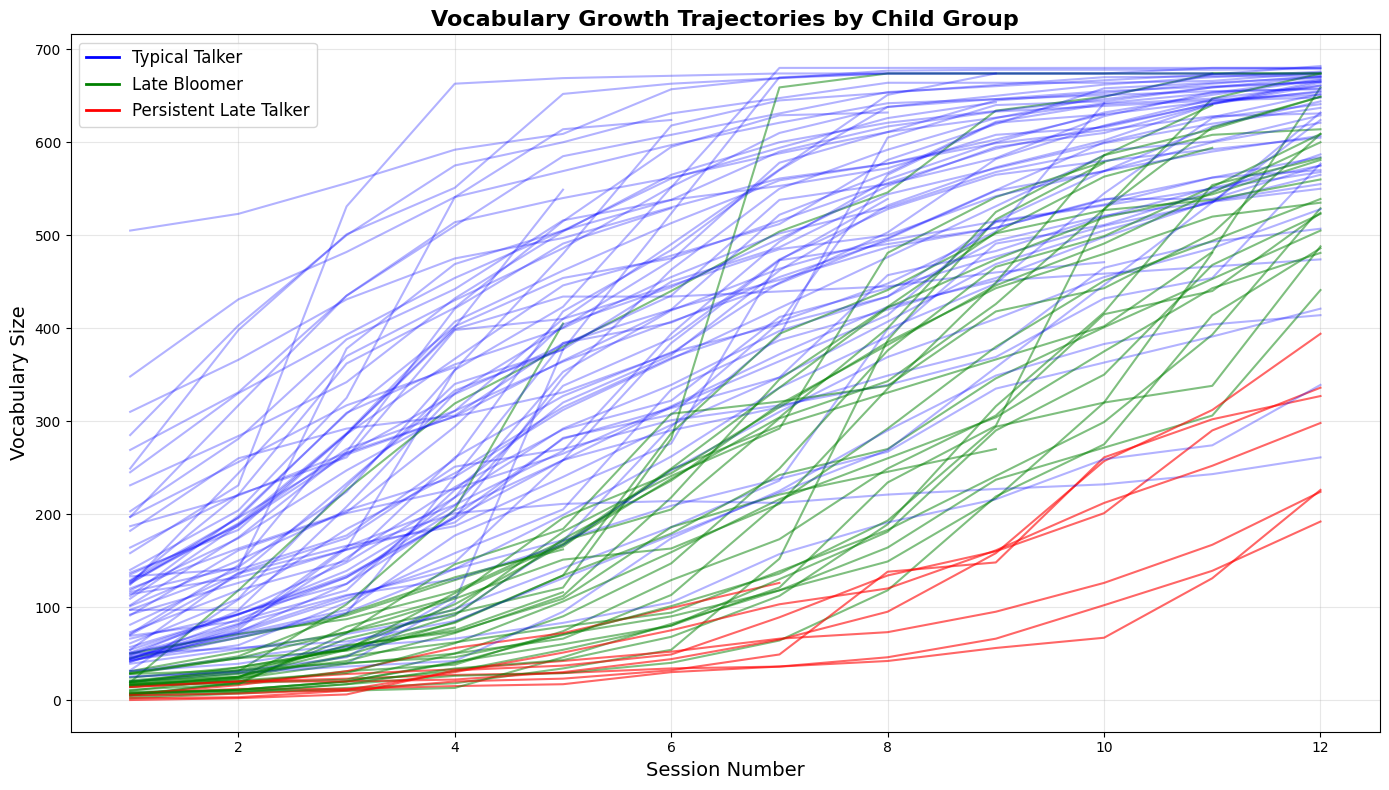

TRAJECTORY SUMMARY
Child 4139 (TT): 10 sessions, vocab 91.0→474.0 (Δ383.0)
Child 4155 (TT): 10 sessions, vocab 57.0→644.0 (Δ587.0)
Child 4162 (TT): 10 sessions, vocab 124.0→665.0 (Δ541.0)
Child 4186 (TT): 9 sessions, vocab 114.0→630.0 (Δ516.0)
Child 4189 (LB): 10 sessions, vocab 45.0→659.0 (Δ614.0)
Child 4210 (TT): 9 sessions, vocab 112.0→666.0 (Δ554.0)
Child 4214 (PLT): 12 sessions, vocab 14.0→192.0 (Δ178.0)
Child 4247 (TT): 11 sessions, vocab 285.0→675.0 (Δ390.0)
Child 4248 (TT): 12 sessions, vocab 97.0→671.0 (Δ574.0)
Child 4250 (LB): 10 sessions, vocab 2.0→578.0 (Δ576.0)
Child 4261 (TT): 11 sessions, vocab 158.0→680.0 (Δ522.0)
Child 4264 (TT): 12 sessions, vocab 249.0→674.0 (Δ425.0)
Child 4265 (TT): 10 sessions, vocab 48.0→568.0 (Δ520.0)
Child 4267 (TT): 7 sessions, vocab 43.0→539.0 (Δ496.0)
Child 4270 (TT): 11 sessions, vocab 269.0→668.0 (Δ399.0)
Child 4272 (PLT): 11 sessions, vocab 7.0→226.0 (Δ219.0)
Child 4273 (TT): 10 sessions, vocab 45.0→671.0 (Δ626.0)
Child 4276 (TT): 12 sessi

In [10]:
import matplotlib.pyplot as plt

# Create the plot
fig, ax = plt.subplots(figsize=(14, 8))

# Plot each child's trajectory
for child_id, group in CDI.groupby('child_id'):
    group = group.sort_values('session_num')
    
    # Determine child's group
    late_talker = group['Late_Talker'].iloc[0]
    plt_status = group['Persistent_Late_Talker'].iloc[0]
    
    if late_talker == 0:
        color = 'blue'
        label = 'Typical Talker'
        alpha = 0.3
    elif late_talker == 1 and plt_status == 0:
        color = 'green'
        label = 'Late Bloomer'
        alpha = 0.5
    else:  # late_talker == 1 and plt_status == 1
        color = 'red'
        label = 'Persistent Late Talker'
        alpha = 0.6
    
    # Plot this child's trajectory
    ax.plot(group['session_num'], group['vocab_size'], 
            color=color, alpha=alpha, linewidth=1.5)

# Create custom legend (to avoid duplicate labels)
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='blue', linewidth=2, label='Typical Talker'),
    Line2D([0], [0], color='green', linewidth=2, label='Late Bloomer'),
    Line2D([0], [0], color='red', linewidth=2, label='Persistent Late Talker')
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=12)

# Labels and formatting
ax.set_xlabel('Session Number', fontsize=14)
ax.set_ylabel('Vocabulary Size', fontsize=14)
ax.set_title('Vocabulary Growth Trajectories by Child Group', fontsize=16, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Optional: Print summary stats
print("=" * 60)
print("TRAJECTORY SUMMARY")
print("=" * 60)
for child_id, group in CDI.groupby('child_id'):
    group = group.sort_values('session_num')
    first_vocab = group['vocab_size'].iloc[0]
    last_vocab = group['vocab_size'].iloc[-1]
    growth = last_vocab - first_vocab
    num_sessions = len(group)
    
    late_talker = group['Late_Talker'].iloc[0]
    plt_status = group['Persistent_Late_Talker'].iloc[0]
    
    if late_talker == 0:
        group_name = "TT"
    elif plt_status == 0:
        group_name = "LB"
    else:
        group_name = "PLT"
    
    print(f"Child {child_id} ({group_name}): {num_sessions} sessions, "
          f"vocab {first_vocab}→{last_vocab} (Δ{growth})")

In [11]:
# Export cleaned dataset to CSV
output_filename = 'CDI_cleaned.csv'

CDI.to_csv(output_filename, index=False)

print("=" * 60)
print("EXPORT COMPLETE")
print("=" * 60)
print(f"File saved as: {output_filename}")
print(f"Total rows: {len(CDI)}")
print(f"Total children: {CDI['child_id'].nunique()}")
print(f"Columns: {len(CDI.columns)}")
print(f"\nColumns included:")
for col in CDI.columns:
    print(f"  - {col}")

EXPORT COMPLETE
File saved as: CDI_cleaned.csv
Total rows: 1136
Total children: 109
Columns: 713

Columns included:
  - child_id
  - study id
  - study
  - gender
  - age
  - birthday
  - session_date
  - session_num
  - total num sessions
  - words_spoken
  - items excluded
  - percentile
  - extra categories
  - revision
  - languages
  - num languages
  - cdi type
  - hard of hearing
  - deleted
  - baa baa
  - choo choo
  - cockadoodledoo
  - grr
  - meow
  - moo
  - ouch
  - quack quack
  - uh oh
  - vroom
  - woof woof
  - yum yum
  - alligator
  - animal
  - ant
  - bear
  - bee
  - bird
  - bug
  - bunny
  - butterfly
  - cat
  - chicken(animal)
  - cow
  - deer
  - dog
  - donkey
  - duck
  - elephant
  - fish(animal)
  - frog
  - giraffe
  - goose
  - hen
  - horse
  - kitty
  - lamb
  - lion
  - monkey
  - moose
  - mouse
  - owl
  - penguin
  - pig
  - pony
  - puppy
  - rooster
  - sheep
  - squirrel
  - teddybear
  - tiger
  - turkey
  - turtle
  - wolf
  - zebra
  - airp

In [1]:
import pandas as pd
import numpy as np
from scipy import stats


#Cleaning CDI Data
CDI_raw = pd.read_csv("/Users/abbyhultquist/Documents/First Year Project/CDI_raw.csv")
CDI = CDI_raw.copy()

print("Initial CDI shape:", CDI.shape)
CDI = CDI.sort_values(['child_id', 'session_num'])



#creating a list of ALL words 
word_cols = CDI.columns[19:].tolist()

print("total # words considered:", len(word_cols))
print()




# Remove children with less than 4 sessions
session_counts = CDI.groupby('child_id')['session_num'].count()
valid_children = session_counts[session_counts >= 4].index
CDI = CDI[CDI['child_id'].isin(valid_children)]

print(f"After removing children with <4 sessions: {CDI.shape}")
print(f"Removed {len(session_counts) - len(valid_children)} children with < 4 sessions")


# Find and remove outliers
outliers_sessions = set(CDI[CDI['session_num'] > 12]['child_id'])
outliers_vocab = set(CDI[CDI['words_spoken'] > len(word_cols)]['child_id'])
z_scores = stats.zscore(CDI['words_spoken'])
outliers_zscore = set(CDI[np.abs(z_scores) > 3]['child_id'])

all_outliers = outliers_sessions | outliers_vocab | outliers_zscore

print(f"Removed {len(all_outliers)} additional outlier children:")
print(f"  - {len(outliers_sessions)} for session_num > 12")
print(f"  - {len(outliers_vocab)} for vocab_size > # words in CDI")
print(f"  - {len(outliers_zscore)} for zscore > 3 on vocab_size")

CDI = CDI[~CDI['child_id'].isin(all_outliers)].copy()

print(f"After removing outliers: {CDI.shape}")






#Once a word is learned, it stays learned
grouped = CDI.groupby('child_id')
for child_id, group in grouped:
    group = group.sort_values('session_num')
    for word in word_cols:
        # Find first session where word is known
        known_sessions = group[group[word] == 1]['session_num']
        if not known_sessions.empty:
            first_known = known_sessions.min()
            # Set word as known from first_known onwards
            CDI.loc[(CDI['child_id'] == child_id) & (CDI['session_num'] >= first_known), word] = 1
# Update words_spoken to reflect the cumulative knowledge
CDI['words_spoken'] = CDI[word_cols].sum(axis=1)


print()
print("After ensuring cumulative knowledge and recalculating vocab_size")




#defining late talkers (0 = TT, 1 = LT)
#defining PLT (0 = Late bloomer, 1 = PLT, NA means they are a TT)
CDI["Late_Talker"] = 0
CDI["Persistent_Late_Talker"] = np.nan #Only LT get set to 0 or 1

grouped = CDI.groupby('child_id')

for child_id, group in grouped:
    first_session = group['session_num'].min()
    last_session = group['session_num'].max()
    
    # Check first session for this child
    first_session_data = group[group['session_num'] == first_session]
    
    if len(first_session_data) > 0:
        if first_session_data['percentile'].values[0] < 20:
            CDI.loc[CDI['child_id'] == child_id, 'Late_Talker'] = 1
        else:
            CDI.loc[CDI['child_id'] == child_id, 'Late_Talker'] = 0
    
    # Check last session for this child
    last_session_data = group[group['session_num'] == last_session]
    
    if len(last_session_data) > 0:
        late_talker_status = CDI.loc[CDI['child_id'] == child_id, 'Late_Talker'].values[0]
        
        if late_talker_status == 1:  # Was a late talker
            if last_session_data['percentile'].values[0] < 20:  # FIXED: Still below 20%
                CDI.loc[CDI['child_id'] == child_id, 'Persistent_Late_Talker'] = 1
            else:  # Improved (late bloomer)
                CDI.loc[CDI['child_id'] == child_id, 'Persistent_Late_Talker'] = 0
        else:  # Not a late talker
            CDI.loc[CDI['child_id'] == child_id, 'Persistent_Late_Talker'] = np.nan  # FIXED: Use np.nan

# Verify 
print("Late Talkers:", CDI[CDI['Late_Talker'] == 1]['child_id'].nunique())
print("Persistent Late Talkers:", CDI[CDI['Persistent_Late_Talker'] == 1]['child_id'].nunique())
print("Late Bloomers:", CDI[(CDI['Late_Talker'] == 1) & (CDI['Persistent_Late_Talker'] == 0)]['child_id'].nunique())

print("Final CDI shape:", CDI.shape)






Initial CDI shape: (1168, 708)
total # words considered: 689

After removing children with <4 sessions: (1155, 708)
Removed 11 children with < 4 sessions
Removed 1 additional outlier children:
  - 1 for session_num > 12
  - 0 for vocab_size > # words in CDI
  - 0 for zscore > 3 on vocab_size
After removing outliers: (1142, 708)

After ensuring cumulative knowledge and recalculating vocab_size
Late Talkers: 41
Persistent Late Talkers: 8
Late Bloomers: 33
Final CDI shape: (1142, 710)
